Check the GPU, make sure it is Tesla P100-PCIE or V100-SXM2

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Wed Jun 16 03:44:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Connect Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
#!pip install -U albumentations>=0.3.0 --user 
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install -U --pre segmentation-models --user
# https://github.com/keras-team/keras/issues/14265#issuecomment-720376773
!pip install h5py==2.10.0

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-5k5ba1pe
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-5k5ba1pe
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=3730c3515da324577e621bcfc3ef93ad0b22f1ad076439b5da8985308d2f24dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-12d4tnf8/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 2.9MB 4.1MB/s 
ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


Restart Runtime then execute the following cells

##Import libraries
#### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [1]:
%tensorflow_version 1.x

import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

TensorFlow 1.x selected.
1.15.2
2.3.1


Using TensorFlow backend.


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

# Loading dataset

 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 512 pixels height and 512 pixels width.

**The mask image is an 1 channel png image with classes as its pixel value**

In [4]:
!wget --no-check-certificate \
    https://djangocolab.blob.core.windows.net/aidatacolab2/chimei_4626_514.zip \
    -O chimei_4626_514.zip

--2021-06-16 03:46:06--  https://djangocolab.blob.core.windows.net/aidatacolab2/chimei_4626_514.zip
Resolving djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)... 20.150.86.132
Connecting to djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)|20.150.86.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 364493315 (348M) [application/zip]
Saving to: ‘chimei_4626_514.zip’

chimei_4626_514.zip 100%[===================>] 347.61M  6.54MB/s    in 56s     

2021-06-16 03:47:03 (6.18 MB/s) - ‘chimei_4626_514.zip’ saved [364493315/364493315]



In [5]:
!unzip -q chimei_4626_514.zip
!rm -r __MACOSX

## Delete hidden files from Mac

In [6]:
f_t_c = "chimei_4626_514"

for i in os.listdir(os.path.join(f_t_c, "train")):
  if i.startswith('.'):
    print(i)
    os.remove(os.path.join(f_t_c, "train", i))
for i in os.listdir(os.path.join(f_t_c, "trainannot")):
  if i.startswith('.'):
    print(i)
    os.remove(os.path.join(f_t_c, "trainannot", i))
for i in os.listdir(os.path.join(f_t_c, "val")):
  if i.startswith('.'):
    print(i)
    os.remove(os.path.join(f_t_c, "val", i))
for i in os.listdir(os.path.join(f_t_c, "valannot")):
  if i.startswith('.'):
    print(i)
    os.remove(os.path.join(f_t_c, "valannot", i))

In [7]:
!mkdir CamVid
!mv chimei_4626_514/* CamVid/

!mkdir CamVid/test/
!mkdir CamVid/testannot/

In [8]:
train_folder = 'CamVid/train/'
train_L_folder = 'CamVid/trainannot/'
print("total images in train folder: ", len(os.listdir(train_folder)))
print("total images in train_L folder: ", len(os.listdir(train_L_folder)))

val_folder = 'CamVid/val/'
val_L_folder = 'CamVid/valannot/'
print("total images in val folder: ", len(os.listdir(val_folder)))
print("total images in val_L folder: ", len(os.listdir(val_L_folder)))

test_folder = 'CamVid/test/'
test_L_folder = 'CamVid/testannot/'
print("total images in test folder: ", len(os.listdir(test_folder)))
print("total images in test_L folder: ", len(os.listdir(test_L_folder)))

total images in train folder:  4626
total images in train_L folder:  4626
total images in val folder:  514
total images in val_L folder:  514
total images in test folder:  0
total images in test_L folder:  0


In [9]:
DATA_DIR = './CamVid/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# Dataloader and utility functions 

In [10]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(20, 5)) #16,5
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        # plt.xticks([])
        # plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bg', 'heart'] #, 'unlabelled'
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

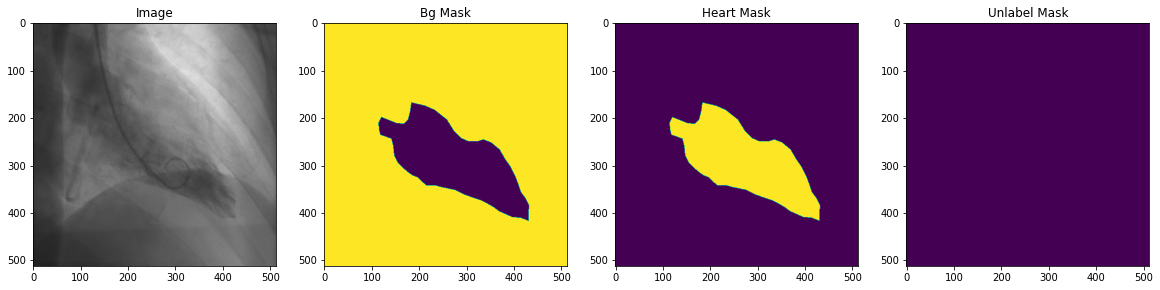

(512, 512, 3)


In [11]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['bg', 'heart'])

image, mask = dataset[58] # get some sample
visualize(
    image=image, 
    bg_mask=mask[..., 0].squeeze(),
    heart_mask=mask[..., 1].squeeze(),
    unlabel_mask=mask[..., 2].squeeze()
)

print(mask.shape)

### Augmentations

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.

In [12]:
import albumentations as A

In [13]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        # A.HorizontalFlip(p=0.5),

        #A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0, p=0.5, border_mode=0), # strong augmentation
        # A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0, p=0.3, border_mode=0), # weak augmentation

        A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        A.RandomCrop(height=512, width=512, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        
        A.IAAPerspective(p=0.5), # strong augmentation
        # A.IAAPerspective(p=0.3), # weak augmentation

        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0, p=0.3), # strong augmentation

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9, # strong augmentation
            # p=0.3, # weak augmentation
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9, # strong augmentation
            # p=0.3, # weak augmentation
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9, # strong augmentation
            # p=0.3, # weak augmentation
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.RandomCrop(height=512, width=512, always_apply=True),
        A.PadIfNeeded(512, 512)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

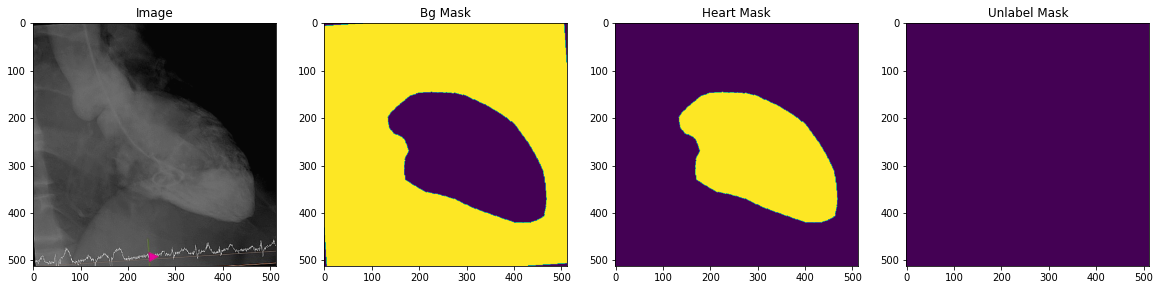

(512, 512, 3)


In [14]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['bg', 'heart'], augmentation=get_training_augmentation())

image, mask = dataset[11] # get some sample
visualize(
    image=image, 
    bg_mask=mask[..., 0].squeeze(),
    heart_mask=mask[..., 1].squeeze(),
    unlabel_mask=mask[..., 2].squeeze()
)

print(mask.shape)

# Segmentation model training

In [15]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


Setting manual: https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones

In [16]:
BACKBONE = "efficientnetb4" #'efficientnetb4' 'resnet50'
BATCH_SIZE = 4 #4 8
CLASSES = ['bg', 'heart']
LR = 0.0001 #0.0001 0.01
EPOCHS = 40 #40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [17]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation) #, encoder_weights=None

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
71892992/71892840 [==============================] - 4s 0us/step


## Set loss and metrics

In [18]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss ['bg', 'heart', 'unlabelled']
# class_weights=np.array([0.5, 1, 0.01]) pixel 0-1 level 

# dice_loss = sm.losses.DiceLoss() #class_weights=np.array([0.5, 1, 0.01])
jaccard_loss = sm.losses.JaccardLoss(class_weights=np.array([0.2, 1, 0.01])) #class_weights=np.array([0.5, 1, 0.01]) 

focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# ce_loss = sm.losses.BinaryCELoss() if n_classes == 1 else sm.losses.CategoricalCELoss() #class_weights=np.array([0.5, 1, 0.01]) 

# total_loss = dice_loss + (1 * focal_loss)
# total_loss = dice_loss + (1 * ce_loss)
total_loss = jaccard_loss + (1 * focal_loss)
# total_loss = jaccard_loss + (1 * ce_loss)
# total_loss = ce_loss

metrics = [sm.metrics.IOUScore(threshold=0.5, class_indexes=[1]), # , class_indexes=[1]
          #  sm.metrics.FScore(threshold=0.5), # , class_indexes=[1]
          #  sm.metrics.Precision(threshold=0.5), # , class_indexes=[1]
           sm.metrics.Recall(threshold=0.5, class_indexes=[1])] # , class_indexes=[1]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

## Load dataset

In [19]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, n_classes)

assert valid_dataloader[0][0].shape == (1, 512, 512, 3)
assert valid_dataloader[0][1].shape == (1, 512, 512, n_classes)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

## Define callbacks for learning rate scheduling and best checkpoints saving

In [20]:
def my_scheduler(epoch, lr):
  if epoch < 31:
    return lr
  else:
    return 0.00001 # lr * tf.math.exp(-0.1)

callbacks = [
    # monitor='val_iou_score', mode='max' # mode='min'
    keras.callbacks.ModelCheckpoint('drive/MyDrive/colab_data/chimei/checkpoints/UNet/UNET_4626_1to40_jf_{epoch:02d}_{val_iou_score:.2f}_model.h5', save_weights_only=True, save_best_only=True, monitor='val_iou_score', mode='max'),
    keras.callbacks.ReduceLROnPlateau(patience=12, verbose=1), # patience=12, min_lr=0.00001
    # keras.callbacks.LearningRateScheduler(schedule=my_scheduler, verbose=1)
    keras.callbacks.CSVLogger('drive/MyDrive/colab_data/chimei/checkpoints/UNet/UNET_4626_1to40_jf_model.csv')
]

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau  

## Train the model

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

model.save_weights('drive/MyDrive/colab_data/chimei/checkpoints/UNet/UNET_4626_1to40_jf_40_model.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/40
1156/1156 [==============================] - 700s 606ms/step - loss: 0.6986 - iou_score: 0.8200 - recall: 0.9168 - val_loss: 0.6800 - val_iou_score: 0.8915 - val_recall: 0.9449
Epoch 2/40
1156/1156 [==============================] - 666s 576ms/step - loss: 0.6509 - iou_score: 0.8846 - recall: 0.9406 - val_loss: 0.6919 - val_iou_score: 0.8996 - val_recall: 0.9490
Epoch 3/40
1156/1156 [==============================] - 666s 576ms/step - loss: 0.6459 - iou_score: 0.8944 - recall: 0.9453 - val_loss: 0.6863 - val_iou_score: 0.9012 - val_recall: 0.9619
Epoch 4/40
1156/1156 [==============================] - 666s 576ms/step - loss: 0.6434 - iou_score: 0.8998 - recall: 0.9480 - val_loss: 0.7109 - val_iou_score: 0.9091 - val_recall: 0.9577
Epoch 5/40
1156/1156 [==============================] - 666s 576ms/step - loss: 0.6415 - iou_score: 0.9040 - recall: 0.9507 - val_loss: 0.7329 - val_iou_

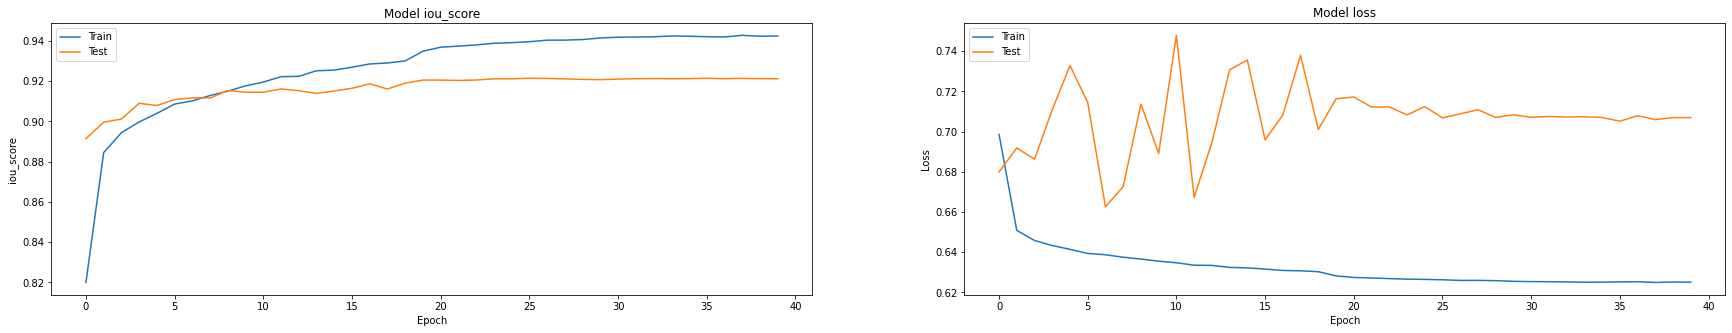

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

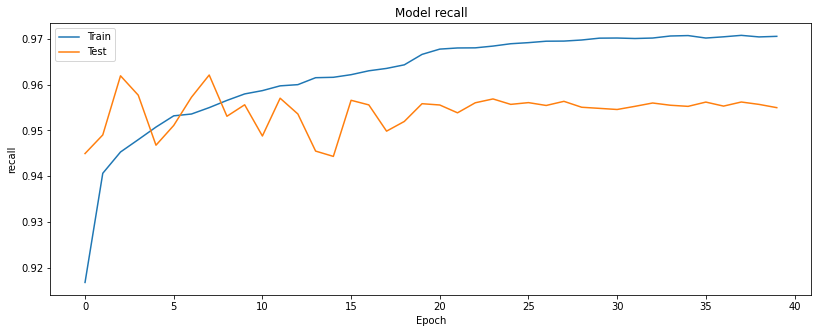

In [ ]:
# Plot training & validation precision values
plt.figure(figsize=(30, 5))
# plt.subplot(121)
# plt.plot(history.history['precision'])
# plt.plot(history.history['val_precision'])
# plt.title('Model precision')
# plt.ylabel('precision')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation recall values
plt.subplot(122)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [21]:
test_dataset = Dataset(
    x_valid_dir, # x_valid_dir,
    y_valid_dir, # y_valid_dir
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


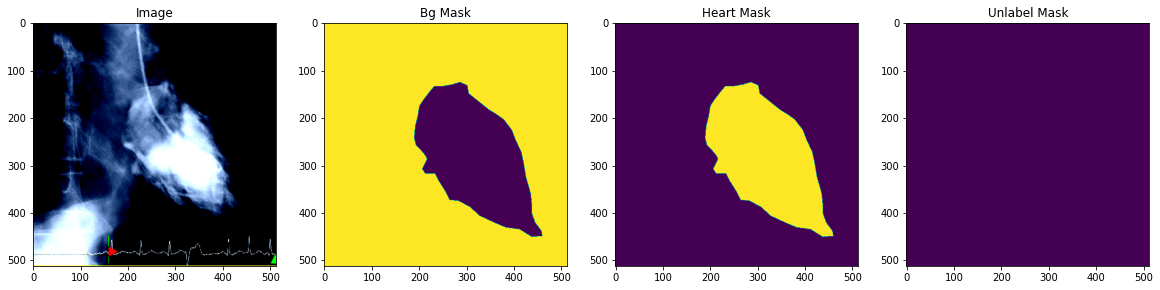

In [22]:
image, mask = test_dataset[8] # get some sample
visualize(
    image=image, 
    bg_mask=mask[..., 0].squeeze(),
    heart_mask=mask[..., 1].squeeze(),
    unlabel_mask=mask[..., 2].squeeze()
)

##Load weights

In [23]:
# !wget https://djangocolab.blob.core.windows.net/aidatacolab2/UNET_1304_1to40_jf_40_0.97_model.h5
# model.load_weights('UNET_1304_1to40_jf_40_0.97_model.h5')

# load weights
model.load_weights('drive/MyDrive/colab_data/chimei/checkpoints/UNet/20210609/UNET_4626_1to40_jf_26_0.92_model.h5') 

In [24]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.4}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.4}".format(metric.__name__, value))


Loss: 0.6204
mean iou_score: 0.9215
mean recall: 0.9561


## Calculate TMUH IoU Score

calculate average score for all classes, full score is 2.

In [ ]:
total_test_images = len(os.listdir(val_folder)) # val_folder
total_labels = [0,1]
iou_threshold = 0.5

score_now = 0

for i in range(total_test_images):
    # get the predicted mask
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = np.squeeze(model.predict(image))
    pr_mask = np.round(pr_mask)
    # print(gt_mask.shape)
    # print(pr_mask.shape)

    # calculate IoU score of each class
    for j in total_labels:
      if np.sum(gt_mask[:,:,j]) == 0 and np.sum(pr_mask[:,:,j]) == 0:
        score_now = score_now + 1
      else:
        intersection = np.sum(gt_mask[:,:,j] * pr_mask[:,:,j])
        union = np.sum(gt_mask[:,:,j] + pr_mask[:,:,j]) - intersection
        iou = intersection / union
        if iou > iou_threshold:
          score_now = score_now + 1

print("total score:", score_now)
print("total test images:", total_test_images)
print("average IoU score:", round((score_now / total_test_images)/len(total_labels), 4))

total score: 1027
total test images: 514
average IoU score: 0.999


calculate average score for each class, full score is 1 per class.

In [ ]:
total_test_images = len(os.listdir(val_folder)) # val_folder
total_labels = [0,1]
iou_threshold = 0.5

for j in total_labels:
  score_now = 0
  empty_label = 0
  correct_predicted = 0
  for i in range(total_test_images):
      # get the predicted mask
      image, gt_mask = test_dataset[i]
      image = np.expand_dims(image, axis=0)
      pr_mask = np.squeeze(model.predict(image))
      pr_mask = np.round(pr_mask)

      # calculate IoU score of each class
      if np.sum(gt_mask[:,:,j]) == 0:
        empty_label = empty_label + 1
      if np.sum(gt_mask[:,:,j]) == 0 and np.sum(pr_mask[:,:,j]) == 0:
        score_now = score_now + 1
      else:
        intersection = np.sum(gt_mask[:,:,j] * pr_mask[:,:,j])
        union = np.sum(gt_mask[:,:,j] + pr_mask[:,:,j]) - intersection
        iou = intersection / union
        if iou > iou_threshold:
          score_now = score_now + 1
          correct_predicted = correct_predicted + 1
  print(CLASSES[j], "total score:", score_now)
  print(CLASSES[j], "correct predicted count:", correct_predicted)
  print(CLASSES[j], "correct not predicted count:", score_now - correct_predicted)
  print("total test images:", total_test_images)
  print("gt label count:", total_test_images - empty_label)
  print("gt no label count:", empty_label)
  print(CLASSES[j], "average IoU score:", round(score_now / total_test_images, 4))
  print("*"*100)

bg total score: 514
bg correct predicted count: 514
bg correct not predicted count: 0
total test images: 514
gt label count: 514
gt no label count: 0
bg average IoU score: 1.0
****************************************************************************************************
heart total score: 513
heart correct predicted count: 513
heart correct not predicted count: 0
total test images: 514
gt label count: 514
gt no label count: 0
heart average IoU score: 0.9981
****************************************************************************************************


# Visualization of results on test dataset

In [63]:
def draw_color(input_image, mask_image):
    colors = [(0,0,0),      #bg
              (250,0,0),    #heart
              (0,0,0)]       #unlabel
    classes = ['bg', 'heart', 'unlabelled']
    out_image = np.zeros_like(input_image)
    #print("mask image shape is:", mask_image.shape)
    for i in range(len(classes)):
        class_mask = mask_image[...,i] # get the layer of class
        class_mask = np.stack((class_mask * colors[i][0], class_mask * colors[i][1], class_mask * colors[i][2]), axis=-1)
        out_image = out_image + class_mask
    
    out_image= out_image.astype(int) # make it int so plt.imshow can show rgb 0-255, float will show 0-1
    return out_image

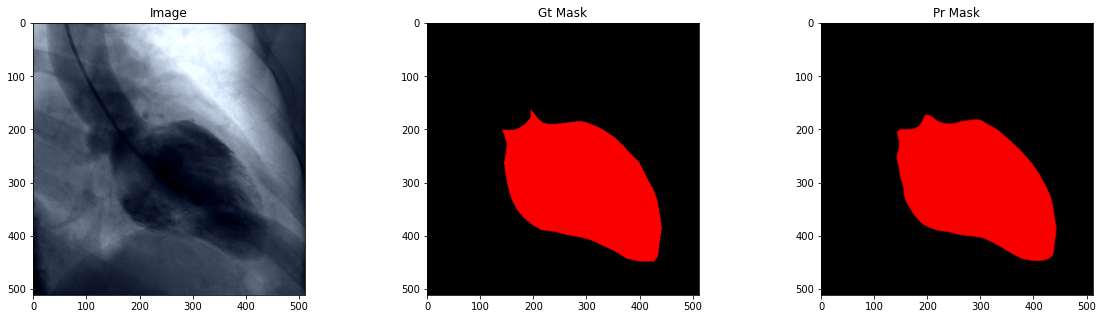

(1, 512, 512, 3)
(1, 512, 512, 3)


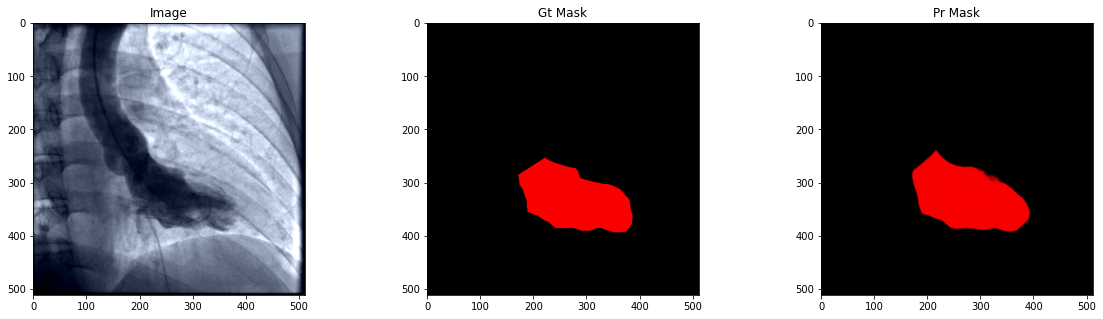

(1, 512, 512, 3)
(1, 512, 512, 3)


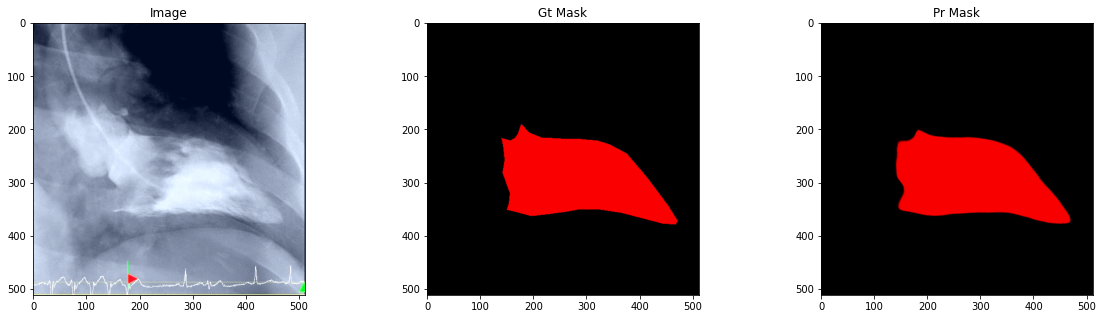

(1, 512, 512, 3)
(1, 512, 512, 3)


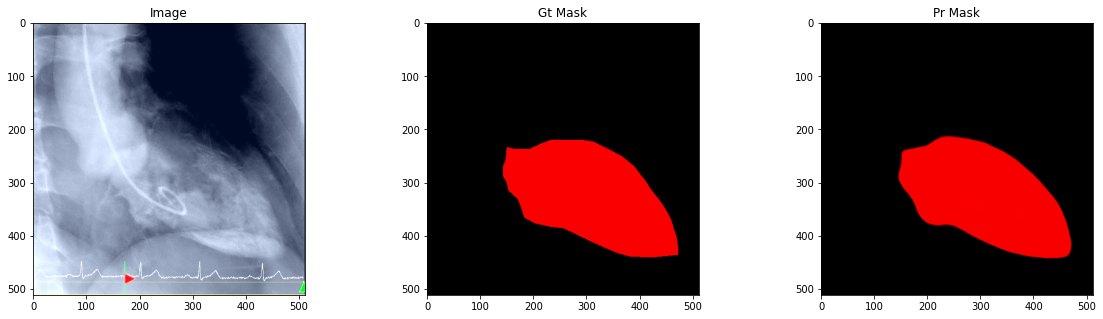

(1, 512, 512, 3)
(1, 512, 512, 3)


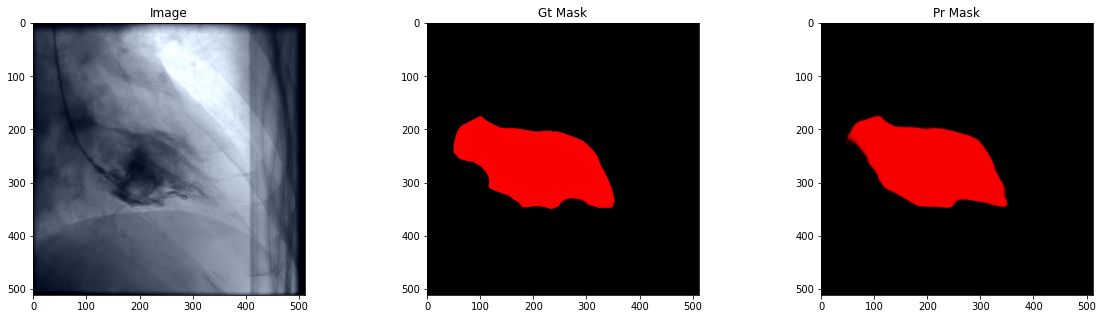

(1, 512, 512, 3)
(1, 512, 512, 3)


In [ ]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    gt_mask = draw_color(image, gt_mask)
    pr_mask = draw_color(image, pr_mask)

    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

    print(gt_mask.shape)
    print(pr_mask.shape)

# Test dataset predicted mask for submission

## Download test dataset

In [47]:
!wget --no-check-certificate \
    https://djangocolab.blob.core.windows.net/aidatacolab2/chimei_test_20210128.zip\
    -O chimei_test_20210128.zip

!unzip -q chimei_test_20210128.zip
!rm -r __MACOSX

--2021-06-16 05:33:48--  https://djangocolab.blob.core.windows.net/aidatacolab2/chimei_test_20210111.zip
Resolving djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)... 20.150.86.132
Connecting to djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)|20.150.86.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75242818 (72M) [application/zip]
Saving to: ‘chimei_test_20210111.zip’

chimei_test_2021011 100%[===================>]  71.76M  19.8MB/s    in 4.0s    

2021-06-16 05:33:53 (18.2 MB/s) - ‘chimei_test_20210111.zip’ saved [75242818/75242818]



In [363]:
!rm -r CamVid/test/*
!rm -r CamVid/testannot/*

rm: cannot remove 'CamVid/testannot/*': No such file or directory


In [364]:
test_target = "C4326"

# !cp 20210111/0533/0533/* CamVid/test/
!cp 20210128/C4326/images/* CamVid/test/
# !cp CamVid/train/20492* CamVid/test/
# !cp CamVid/val/20492* CamVid/test/

## Util for generating all predicted masks

In [28]:
from PIL import Image
from skimage import io
import random as rng

In [29]:
def save_color(pr_mask, pr_mask_path, need_resize, target_width, target_height):
    colors = [(0,0,0),      #bg
              (250,0,0),    #heart
              (0,0,0)]       #unlabel

    height, width = pr_mask.shape[0], pr_mask.shape[1]
    img_mask = Image.new(mode = "RGB", size = (width, height))
    px = img_mask.load()

    for x in range(0,width):
        for y in range(0,height):
             px[x,y] = colors[pr_mask[y][x]]
    # resize if the original size is not 512*512
    if need_resize is True:
        img_mask = img_mask.resize((target_width, target_height), Image.NEAREST)
        
    img_mask.save(pr_mask_path)

def visualize_test(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(6, 3)) #16,5
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        # plt.xticks([])
        # plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def draw_combined_color(mask_image):
    colors = {0:0,      #bg 0
              1:250,    #diastole 1
              -1:100}    #systole -1

    out_image = np.zeros_like(mask_image)

    for k,v in colors.items():
        class_mask = (mask_image==k) # get the layer of class
        class_mask = class_mask * colors[k]
        out_image = out_image + class_mask
    
    out_image= out_image.astype(int) # make it int so plt.imshow can show rgb 0-255, float will show 0-1
    return out_image
  
def get_enclosing_circle(pr_mask, threshold=100):
    """
    input:
        pr_mask is numpy array with shape (width height)
        threshold max 255 default 100
    outputs:
        enclosing circle center and radius
    """
    colors = [0,      #bg
              250,    #heart
              0]      #unlabel

    height, width = pr_mask.shape[0], pr_mask.shape[1]
    img_mask = Image.new(mode = "L", size = (width, height))
    px = img_mask.load()

    for x in range(0,width):
        for y in range(0,height):
             px[x,y] = colors[pr_mask[y][x]]
        
    img_mask.save("enclosing.jpg")
    # cv2 process from here
    src = cv2.imread("enclosing.jpg")
    src_blur = cv2.blur(src, (3,3))
    # cv2.imwrite("enclosing_blur.jpg", src_blur)
    # Detect edges using Canny
    canny_output = cv2.Canny(src_blur, threshold, threshold * 2)
    # cv2.imwrite("enclosing_canny.jpg", canny_output)
    # Find contours
    contours, _ = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Approximate contours to polygons + get bounding rects and circles
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        centers[i], radius[i] = cv2.minEnclosingCircle(contours_poly[i])
    # draw result
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    # Draw polygonal contour + bonding rects + circles
    temp_i = 0
    temp_r = 0
    for i in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv2.drawContours(drawing, contours_poly, i, color)
        cv2.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)
        # keep the biggest circle for output
        if int(radius[i]) > temp_r:
          temp_r = int(radius[i])
          temp_i = i
    # cv2.imwrite('enclosing_contours.jpg', drawing)
    return int(centers[temp_i][0]), int(centers[temp_i][1]), int(radius[temp_i])

https://docs.opencv.org/3.4/da/d0c/tutorial_bounding_rects_circles.html

## Generate all predicted masks

In [365]:
# !rm -r drive/MyDrive/colab_data/chimei/chimei_predicted/*
!mkdir tmp
!rm -r chimei_predicted
!mkdir chimei_predicted

mkdir: cannot create directory ‘tmp’: File exists


### Set folder path

In [366]:
testdata_folder = "CamVid/test/"
# savedata_folder = "drive/MyDrive/colab_data/chimei/chimei_predicted/"
savedata_folder = "chimei_predicted/"

testdatalist = os.listdir(testdata_folder)
# sort the file name
testdatalist.sort()
total_images = len(testdatalist)
print("total test images:", len(testdatalist))

savedatalist = os.listdir(savedata_folder)
print("total predicted images:", len(savedatalist))

total test images: 147
total predicted images: 0


### Find the max and min images

In [367]:
# original images dict
test_dict = dict(enumerate(testdatalist))

width = 512
height = 512
need_resize = False

# count the pixel of heart
heart_max = 0
heart_min = width*height
max_file = str()
min_file = str()
max_key = int()
min_key = int()

# get the max area image
for k,i in enumerate(testdatalist):
    image = io.imread(testdata_folder + i) # novel image
    # check if the size is 512*512
    if image.shape[0] != 512 or image.shape[1] != 512:
        # save the original size for later use
        width = image.shape[1]
        height = image.shape[0]
        need_resize = True
        # resize to 512*512
        im = Image.open(testdata_folder + i) 
        im = im.resize((512, 512)) 
        im.save("tmp/" + i)
        image = io.imread("tmp/" + i)
        
    # convert 1 channel to 3 channel if necessary
    if len(image.shape) == 2:
      image = np.stack((image,)*3, axis=-1)
    image = preprocess_input(image) # use the preprocessing input method based on the backbone you used
    image = np.expand_dims(image, axis = 0)
    pr_mask = model.predict(image) # change the shape to (1, H, W)
    pr_mask = pr_mask.squeeze()
    pr_mask = np.argmax(pr_mask, axis = 2)
    save_color(pr_mask, savedata_folder + i, need_resize, width, height)
    # print("complete ", savedata_folder + i)
    need_resize = False

    # count the pixels of heart(label==1)
    heart = np.sum(pr_mask==1)
    if heart > heart_max:
      heart_max = heart
      max_file = i
      max_key = k
    # if heart < heart_min:
    #   heart_min =heart
    #   min_file = i
    #   min_key = k

# get the min area image, the min image should appear after max image
for k,i in enumerate(testdatalist):
    image = io.imread(testdata_folder + i) # novel image
    # check if the size is 512*512
    if image.shape[0] != 512 or image.shape[1] != 512:
        # save the original size for later use
        width = image.shape[1]
        height = image.shape[0]
        need_resize = True
        # resize to 512*512
        im = Image.open(testdata_folder + i) 
        im = im.resize((512, 512)) 
        im.save("tmp/" + i)
        image = io.imread("tmp/" + i)

    # convert 1 channel to 3 channel if necessary
    if len(image.shape) == 2:
      image = np.stack((image,)*3, axis=-1)
    image = preprocess_input(image) # use the preprocessing input method based on the backbone you used
    image = np.expand_dims(image, axis = 0)
    pr_mask = model.predict(image) # change the shape to (1 H, W)
    pr_mask = pr_mask.squeeze()
    pr_mask = np.argmax(pr_mask, axis = 2)
    # print("complete ", savedata_folder + i)
    need_resize = False

    # count the pixels of heart(label==1)
    heart = np.sum(pr_mask==1)
    if heart < heart_min and k > max_key:
      heart_min = heart
      min_file = i
      min_key = k

# check the results
print("max_key is:", max_key)
print("min_key is:", min_key)

max_key is: 50
min_key is: 61


## Calculate EF by using average area and L

total predicted images: 147
max filename: 00050.jpg


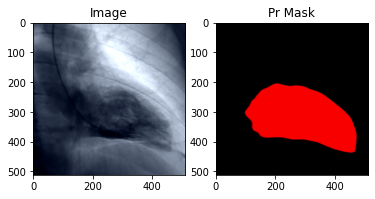

min filename: 00061.jpg


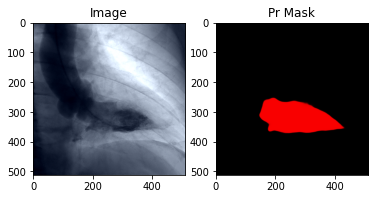

the max area is: [49640, 55004, 56177, 55753, 55170]
the min area is: [22590, 22176, 22059, 23287, 22914]
the L of max area is: [370, 384, 390, 390, 402]
the L of min area is: [280, 288, 286, 282, 282]
EF((EDV-ESV)/EDV): 76.0


In [368]:
# check how many masks were predicted 
savedatalist = os.listdir(savedata_folder)
print("total predicted images:", len(savedatalist))

# set parameters
average_count = 5
max_area_list = []
min_area_list = []
max_L_list = []
min_L_list = []

# draw the max image
print("max filename:", max_file)
image = io.imread(testdata_folder + max_file) 
# convert 1 channel to 3 channel if necessary
if len(image.shape) == 2:
  image = np.stack((image,)*3, axis=-1)
image = preprocess_input(image) # use the preprocessing
image = np.expand_dims(image, axis = 0)
pr_mask = model.predict(image)
### save mask for later combined image use
pr_mask_max = pr_mask 
pr_mask_max = pr_mask_max.squeeze()
pr_mask_max = np.argmax(pr_mask_max, axis = 2)
# print("max shape:", pr_mask_max.shape)
###
pr_mask = draw_color(image, pr_mask)
visualize_test(
        image=denormalize(image.squeeze()),
        pr_mask=pr_mask.squeeze(),
)

# draw the min image
print("min filename:", min_file)
image = io.imread(testdata_folder + min_file) 
# convert 1 channel to 3 channel if necessary
if len(image.shape) == 2:
  image = np.stack((image,)*3, axis=-1)
image = preprocess_input(image) # use the preprocessing
image = np.expand_dims(image, axis = 0)
pr_mask = model.predict(image)
### save mask for later combined image use
pr_mask_min = pr_mask 
pr_mask_min = pr_mask_min.squeeze()
pr_mask_min = np.argmax(pr_mask_min, axis = 2)
# print("min shape:", pr_mask_min.shape)
###
pr_mask = draw_color(image, pr_mask)
visualize_test(
        image=denormalize(image.squeeze()),
        pr_mask=pr_mask.squeeze(),
)

# get the max list
for i in range(average_count):
  if max_key+i-(average_count-1)/2 >= 0 and max_key+i-(average_count-1)/2 < total_images:
    image = io.imread(testdata_folder + test_dict[max_key+i-(average_count-1)/2])
    # convert 1 channel to 3 channel if necessary
    if len(image.shape) == 2:
      image = np.stack((image,)*3, axis=-1)
    # print(test_dict[max_key+i-(average_count-1)/2])
    image = preprocess_input(image) # use the preprocessing
    image = np.expand_dims(image, axis = 0)
    pr_mask = model.predict(image)
    pr_mask = pr_mask.squeeze()
    pr_mask = np.argmax(pr_mask, axis = 2)
    # make sure the value is not too different from the original one
    if abs(heart_max - np.sum(pr_mask==1)) < heart_max*0.2:
      max_area_list.append(np.sum(pr_mask==1))
      _, _, r_max = get_enclosing_circle(pr_mask)
      max_L_list.append(2*r_max)

# get the min list
for i in range(average_count):
  if min_key+i-(average_count-1)/2 >= 0 and min_key+i-(average_count-1)/2 < total_images:
    image = io.imread(testdata_folder + test_dict[min_key+i-(average_count-1)/2]) 
    # convert 1 channel to 3 channel if necessary
    if len(image.shape) == 2:
      image = np.stack((image,)*3, axis=-1)
    # print(test_dict[min_key+i-(average_count-1)/2])
    image = preprocess_input(image) # use the preprocessing
    image = np.expand_dims(image, axis = 0)
    pr_mask = model.predict(image)
    pr_mask = pr_mask.squeeze()
    pr_mask = np.argmax(pr_mask, axis = 2)
    # make sure the value is not too different from the original one
    if abs(heart_min - np.sum(pr_mask==1)) < heart_min*0.2:
      min_area_list.append(np.sum(pr_mask==1))
      _, _, r_min = get_enclosing_circle(pr_mask)
      min_L_list.append(2*r_min)

# print results
print("the max area is:", max_area_list)
print("the min area is:", min_area_list)
print("the L of max area is:", max_L_list)
print("the L of min area is:", min_L_list)

heart_max = sum(max_area_list) / len(max_area_list)
heart_min = sum(min_area_list) / len(min_area_list)
L_max = sum(max_L_list) / len(max_L_list)
L_min = sum(min_L_list) / len(min_L_list)

print("EF((EDV-ESV)/EDV):", 
      round((heart_max**2/L_max - heart_min**2/L_min)/(heart_max**2/L_max),2)*100)

## Draw the combined image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: C4326_combined.png is a low contrast image


{-1: 22059, 0: 240085}
{0: 205967, 1: 56177}
{0: 228026, 1: 34118}


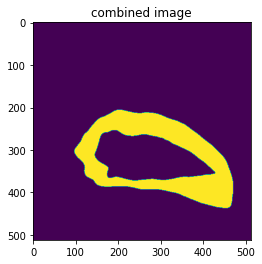

In [369]:
# min image process
pr_mask_min_t = np.where(pr_mask_min == 2, 0, pr_mask_min) # make unlabelled as background
pr_mask_min_t = pr_mask_min_t * -1 # make the systole label as -1 for later calculation
unique, counts = np.unique(pr_mask_min_t, return_counts=True)
print(dict(zip(unique, counts)))

# max image process
pr_mask_max_t = np.where(pr_mask_max == 2, 0, pr_mask_max) # make unlabelled as background
unique, counts = np.unique(pr_mask_max_t, return_counts=True)
print(dict(zip(unique, counts)))

# combine two images
pr_mask_combined = pr_mask_min_t + pr_mask_max_t
unique, counts = np.unique(pr_mask_combined, return_counts=True)
print(dict(zip(unique, counts)))

# draw the image
pr_mask_combined_draw = draw_combined_color(pr_mask_combined)
io.imsave(test_target + "_combined.png", pr_mask_combined_draw)
plt.title('combined image')
plt.imshow(pr_mask_combined_draw)

https://github.com/qubvel/segmentation_models